<a href="https://colab.research.google.com/github/Tauvic/roadsafety/blob/main/Verkeersveiligheid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inzicht in de verkeersveiligheid op buurt en straat nivo

## Doel van dit systeem

Informatie over verkeersongevallen beschikbaar stellen aan burgers zodat deze geinformeerd worden over de verkeersveiligheidsituatie in hun omgeving. Bewoners en andere geintresseerden kunnen met dit hulpmiddel de situatie op gemeente en buurt nivo onderzoeken.

* Is mijn wijk veiliger of onveiliger dan andere wijken
* Waar komen vaak ongevallen voor en wie zijn daar bij betrokken
* Welke maatregelen zijn er getroffen om de veiligheid te verhogen?
* Is er een veilige route naar mijn werk en de school te vinden?

Toon een kaart van nederland met de actuele gemeente en buurt indeling, plaatsen waar ongevallen hebben plaastgevonden en de door de gemeente of provincie genomen verkeersmaatregelen.

[Verkeersongevallen - Bestand geRegistreerde Ongevallen Nederland](https://data.overheid.nl/en/dataset/9841-verkeersongevallen---bestand-geregistreerde-ongevallen-nederland)

*Het bestand geRegistreerde Ongevallen Nederland is een bestand met de ongevallenmeldingen van de politie gekoppeld aan het digitale wegennet (het Nationale Wegenbestand, NWB). Met dit product kunt u verschillende verkeersveiligheidsanalyses voor uw beheersgebied uitvoeren en is in het bijzonder geschikt voor: - beleid (formuleren, monitoren, evalueren), - onderzoek en - wegbeheer.*

## Aantallen
```
  17M mensen
   2M ongevallen periode 2003-2020
13808 buurten 
 3177 wijken
  355 gemeentes
   12 provincies
    1 nederland (vroeger hadden we nog nederland 2)
```

## Data bewerking:

Gebruik de [google colab](https://colab.research.google.com/) python runtime omgeving

* Laad geregistreerde ongevallen [Verkeersongevallen - Bestand geRegistreerde Ongevallen Nederland](https://data.overheid.nl/en/dataset/9841-verkeersongevallen---bestand-geregistreerde-ongevallen-nederland)
* Laad tabel Provincie / Gemeente / Wijk / Buurt (geografische grenzen en aantal inwoners)
  * PDOK Wijk- en Buurtkaart 2020 versie 1
  * https://geodata.nationaalgeoregister.nl/wijkenbuurten2020/wms?request=GetCapabilities
  * Leid de hierarchie af uit de codering
  * We hebben nog geen provincies in onze hierarchie
* Bepaal voor elk ongeval in welke gemeente / wijk / buurt deze plaatsvond op basis van de actuele gemeentelijke indeling
  * Let op oudere ongevallen zijn soms in niet meer bestaande gemeenten geregistreerd dus moeten we ze herindelen tegen de nu geldende situatie
  * Map ongelukken op basis van de buurt grenzen
  * Probleem ongeveer 680 ongevallen vallen net buiten alle grenzen
  * Wellicht moeten we een tabel met gemeentelijke herindeling maken

Kaart projecties:
* Rijksdriehoekstelsel EPSG:28992
* GPS: WGS84

## TO-DO:
* Opschonen en verrijken data:
 * MAXSNELHD (soms groter dan 130 km, soms 100km in woonwijk)
 * Wegsoort (snelweg, deze willen we niet meetellen in een wijk)
 * Binnen / buiten de bebouwde kom (is deze data nodig, grens bebouwde kom is moeilijk te bepalen)
 * Bepaal de maximale snelheid op de weg [WEGGEG](https://data.overheid.nl/en/dataset/bb5bbc65-2a1a-49e4-a9e8-417ae3920703)
 * Laad tabel NWB wegen - Wegvakken (RWS) [documentatie](https://data.overheid.nl/en/dataset/9b50f8a3-7c67-4efb-9046-fb7a57eca18c) [download link](https://geo.rijkswaterstaat.nl/services/ogc/gdr/nwb_wegen/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=wegvakken&outputFormat=csv)
 


In [ ]:
import logging
import sys
root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

import pandas as pd
import numpy as np
import glob
  
# nodig voor geopandas
!apt-get -q install -y libspatialindex-dev && pip install -q -U osmnx 
import osmnx as ox 
ox.config(use_cache=True, log_console=True)
!pip -q install rtree
import rtree
import geopandas as gpd
 
from pyproj import CRS, Transformer

# mapping 
import folium

# CBS open data 
!pip install cbsodata
import cbsodata

#python -m pip uninstall matplotlib
!pip install -q matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# Laad data over geregistereerde ongevallen van rijkswaterstaat

In [ ]:
def download_year(year,municipal,force=True,reference=False,partijen=False):

  logger = logging.getLogger('download')
  
  src_name="01-01-{:d}_31-12-{:d}".format(year,year)
  dir_name="/content/data/"+src_name
  filename=src_name+'.zip'
  logger.info('processing %s',filename)
  
  if force:
    logger.info('loading data')
    !rm -rf $dir_name
    !mkdir -p $dir_name
    !wget -q https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/bron/$filename -O $filename
    !unzip -q $filename -d $dir_name
    !rm -rf $filename
 
  # read accidents
  filename = glob.glob(dir_name+"/**/ongevallen.txt",recursive=True)[0]
  logger.info('loading %s',filename)
  df = pd.read_csv(filename,encoding = "ISO-8859-1",
                   usecols=['VKL_NUMMER',
                            'GME_NAAM',
                            'JAAR_VKL',
                            'NIVEAUKOP',
                            'FK_VELD5',
                            'MAXSNELHD',
                            'AP3_CODE',
                            'ANTL_PTJ',
                            'AOL_ID'],
                   dtype={'GME_ID':np.int16,
                          'GME_NAAM':'category',
                          'JAAR_VKL':np.int16,
                          'NIVEAUKOP':'category',
                          'MAXSNELHD':np.float16,
                          'AP3_CODE':'category',
                          'ANTL_PTJ':np.int8,
                          'AOL_ID':np.int8})
 
  # filter by municipal
  if municipal:
    df = df[ df.GME_NAAM.isin(municipal)]
 
  # read accident locations
  filename = glob.glob(dir_name+"/**/puntlocaties.txt",recursive=True)[0]
  logger.info('loading %s',filename)
  df_detail = pd.read_csv(filename,encoding = "ISO-8859-1",dtype={'X_COORD':np.float64,'Y_COORD':np.float64})
  df = pd.merge(df,df_detail,on='FK_VELD5')
  del df_detail
  #df.drop(['FK_VELD5'], axis=1,inplace=True)
 
  if reference==True:
    # read aflopen
    filename = glob.glob(dir_name+"/**/aflopen3.txt",recursive=True)[0]
    logger.info('loading %s',filename)
    df_detail = pd.read_csv(filename,encoding = "ISO-8859-1",dtype={'AP3_OMS':'category'})
    df = pd.merge(df,df_detail,on='AP3_CODE')
    del df_detail
 
    # read aard ongevallen
    filename = glob.glob(dir_name+"/**/aardongevallen.txt",recursive=True)[0]
    logger.info('loading %s',filename)
    df_detail = pd.read_csv(filename,encoding = "ISO-8859-1",dtype={'AOL_OMS':'category'})
    df = pd.merge(df,df_detail,on='AOL_ID')
    del df_detail
 
    df.drop(['AP3_CODE','GME_ID','PVE_CODE','AOL_ID'], axis=1,inplace=True)
 
  if partijen==True: 
    # read partijen
    filename = glob.glob(dir_name+"/**/partijen.txt",recursive=True)[0]
    logger.info('loading %s',filename)
    df_partij = pd.read_csv(filename,encoding = "ISO-8859-1",usecols=['VKL_NUMMER','OTE_ID'])
    filename = glob.glob(dir_name+"/**/objecttypes.txt",recursive=True)[0]
 
    logger.info('loading %s',filename)
    df_detail = pd.read_csv(filename,encoding = "ISO-8859-1",dtype={'OTE_OMS':'category'})
    df_partij = pd.merge(df_partij,df_detail,on='OTE_ID')
    df_partij.drop(['OTE_ID'], axis=1)
    del df_detail
 
    logger.info('processing partijen')
    df_all = df_partij.groupby(['VKL_NUMMER', 'OTE_OMS']).size().astype(np.int8).unstack(fill_value=0)
    df = df.set_index('VKL_NUMMER').join(df_all)
 
  df.drop(['GME_NAAM','FK_VELD5'], axis=1,inplace=True)
 
  logger.info('done')
 
  return df
 
def download_range(start,end,municipal):
  dfs = []
  for year in range(start,end+1):
    dfs.append(download_year(year,municipal))
 
  df = pd.concat(dfs)
 
  #drop empty columns
  df.dropna(how='all', axis=1, inplace=True)
 
  # transform location coordinates from eps:28922 to WGS84
  transformer = Transformer.from_crs(CRS.from_epsg(28992), CRS.from_epsg(4326))
  df.X_COORD, df.Y_COORD = transformer.transform(df.X_COORD,df.Y_COORD)
 
  #convert to geodataframe
  gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Y_COORD,df.X_COORD),crs=CRS.from_epsg(4326))
 
  return gdf

# Download a time range and specific municipals
df = download_range(2003,2020,['Ermelo','Putten','Harderwijk'])
#df = download_range(2003,2020,None)

df.info()

INFO:download:processing 01-01-2003_31-12-2003.zip


2021-08-05 11:59:28,361 - download - INFO - processing 01-01-2003_31-12-2003.zip
2021-08-05 11:59:28,361 - download - INFO - processing 01-01-2003_31-12-2003.zip


INFO:download:loading data


2021-08-05 11:59:28,367 - download - INFO - loading data
2021-08-05 11:59:28,367 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 11:59:57,352 - download - INFO - loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 11:59:57,352 - download - INFO - loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 11:59:57,857 - download - INFO - loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 11:59:57,857 - download - INFO - loading /content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:00:01,284 - download - INFO - done
2021-08-05 12:00:01,284 - download - INFO - done


INFO:download:processing 01-01-2004_31-12-2004.zip


2021-08-05 12:00:01,293 - download - INFO - processing 01-01-2004_31-12-2004.zip
2021-08-05 12:00:01,293 - download - INFO - processing 01-01-2004_31-12-2004.zip


INFO:download:loading data


2021-08-05 12:00:01,298 - download - INFO - loading data
2021-08-05 12:00:01,298 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:00:25,150 - download - INFO - loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:00:25,150 - download - INFO - loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:00:25,637 - download - INFO - loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:00:25,637 - download - INFO - loading /content/data/01-01-2004_31-12-2004/01-01-2004_31-12-2004/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:00:28,723 - download - INFO - done
2021-08-05 12:00:28,723 - download - INFO - done


INFO:download:processing 01-01-2005_31-12-2005.zip


2021-08-05 12:00:28,730 - download - INFO - processing 01-01-2005_31-12-2005.zip
2021-08-05 12:00:28,730 - download - INFO - processing 01-01-2005_31-12-2005.zip


INFO:download:loading data


2021-08-05 12:00:28,735 - download - INFO - loading data
2021-08-05 12:00:28,735 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:00:51,079 - download - INFO - loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:00:51,079 - download - INFO - loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:00:51,573 - download - INFO - loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:00:51,573 - download - INFO - loading /content/data/01-01-2005_31-12-2005/01-01-2005_31-12-2005/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:00:54,569 - download - INFO - done
2021-08-05 12:00:54,569 - download - INFO - done


INFO:download:processing 01-01-2006_31-12-2006.zip


2021-08-05 12:00:54,575 - download - INFO - processing 01-01-2006_31-12-2006.zip
2021-08-05 12:00:54,575 - download - INFO - processing 01-01-2006_31-12-2006.zip


INFO:download:loading data


2021-08-05 12:00:54,580 - download - INFO - loading data
2021-08-05 12:00:54,580 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:01:22,703 - download - INFO - loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:01:22,703 - download - INFO - loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:01:23,122 - download - INFO - loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:01:23,122 - download - INFO - loading /content/data/01-01-2006_31-12-2006/01-01-2006_31-12-2006/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:01:26,196 - download - INFO - done
2021-08-05 12:01:26,196 - download - INFO - done


INFO:download:processing 01-01-2007_31-12-2007.zip


2021-08-05 12:01:26,204 - download - INFO - processing 01-01-2007_31-12-2007.zip
2021-08-05 12:01:26,204 - download - INFO - processing 01-01-2007_31-12-2007.zip


INFO:download:loading data


2021-08-05 12:01:26,208 - download - INFO - loading data
2021-08-05 12:01:26,208 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:02:02,942 - download - INFO - loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:02:02,942 - download - INFO - loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:02:03,378 - download - INFO - loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:02:03,378 - download - INFO - loading /content/data/01-01-2007_31-12-2007/01-01-2007_31-12-2007/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:02:06,477 - download - INFO - done
2021-08-05 12:02:06,477 - download - INFO - done


INFO:download:processing 01-01-2008_31-12-2008.zip


2021-08-05 12:02:06,483 - download - INFO - processing 01-01-2008_31-12-2008.zip
2021-08-05 12:02:06,483 - download - INFO - processing 01-01-2008_31-12-2008.zip


INFO:download:loading data


2021-08-05 12:02:06,488 - download - INFO - loading data
2021-08-05 12:02:06,488 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:02:33,500 - download - INFO - loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:02:33,500 - download - INFO - loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:02:33,845 - download - INFO - loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:02:33,845 - download - INFO - loading /content/data/01-01-2008_31-12-2008/01-01-2008_31-12-2008/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:02:36,972 - download - INFO - done
2021-08-05 12:02:36,972 - download - INFO - done


INFO:download:processing 01-01-2009_31-12-2009.zip


2021-08-05 12:02:36,979 - download - INFO - processing 01-01-2009_31-12-2009.zip
2021-08-05 12:02:36,979 - download - INFO - processing 01-01-2009_31-12-2009.zip


INFO:download:loading data


2021-08-05 12:02:36,984 - download - INFO - loading data
2021-08-05 12:02:36,984 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:03:00,649 - download - INFO - loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:03:00,649 - download - INFO - loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:03:00,929 - download - INFO - loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:03:00,929 - download - INFO - loading /content/data/01-01-2009_31-12-2009/01-01-2009_31-12-2009/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:03:04,354 - download - INFO - done
2021-08-05 12:03:04,354 - download - INFO - done


INFO:download:processing 01-01-2010_31-12-2010.zip


2021-08-05 12:03:04,362 - download - INFO - processing 01-01-2010_31-12-2010.zip
2021-08-05 12:03:04,362 - download - INFO - processing 01-01-2010_31-12-2010.zip


INFO:download:loading data


2021-08-05 12:03:04,367 - download - INFO - loading data
2021-08-05 12:03:04,367 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:03:31,133 - download - INFO - loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:03:31,133 - download - INFO - loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:03:31,498 - download - INFO - loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:03:31,498 - download - INFO - loading /content/data/01-01-2010_31-12-2010/01-01-2010_31-12-2010/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:03:34,752 - download - INFO - done
2021-08-05 12:03:34,752 - download - INFO - done


INFO:download:processing 01-01-2011_31-12-2011.zip


2021-08-05 12:03:34,762 - download - INFO - processing 01-01-2011_31-12-2011.zip
2021-08-05 12:03:34,762 - download - INFO - processing 01-01-2011_31-12-2011.zip


INFO:download:loading data


2021-08-05 12:03:34,769 - download - INFO - loading data
2021-08-05 12:03:34,769 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:04:11,265 - download - INFO - loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:04:11,265 - download - INFO - loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:04:11,579 - download - INFO - loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:04:11,579 - download - INFO - loading /content/data/01-01-2011_31-12-2011/01-01-2011_31-12-2011/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:04:14,798 - download - INFO - done
2021-08-05 12:04:14,798 - download - INFO - done


INFO:download:processing 01-01-2012_31-12-2012.zip


2021-08-05 12:04:14,809 - download - INFO - processing 01-01-2012_31-12-2012.zip
2021-08-05 12:04:14,809 - download - INFO - processing 01-01-2012_31-12-2012.zip


INFO:download:loading data


2021-08-05 12:04:14,827 - download - INFO - loading data
2021-08-05 12:04:14,827 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:04:44,683 - download - INFO - loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:04:44,683 - download - INFO - loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:04:45,020 - download - INFO - loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:04:45,020 - download - INFO - loading /content/data/01-01-2012_31-12-2012/01-01-2012_31-12-2012/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:04:48,233 - download - INFO - done
2021-08-05 12:04:48,233 - download - INFO - done


INFO:download:processing 01-01-2013_31-12-2013.zip


2021-08-05 12:04:48,240 - download - INFO - processing 01-01-2013_31-12-2013.zip
2021-08-05 12:04:48,240 - download - INFO - processing 01-01-2013_31-12-2013.zip


INFO:download:loading data


2021-08-05 12:04:48,246 - download - INFO - loading data
2021-08-05 12:04:48,246 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:05:17,090 - download - INFO - loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:05:17,090 - download - INFO - loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:05:17,426 - download - INFO - loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:05:17,426 - download - INFO - loading /content/data/01-01-2013_31-12-2013/01-01-2013_31-12-2013/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:05:20,830 - download - INFO - done
2021-08-05 12:05:20,830 - download - INFO - done


INFO:download:processing 01-01-2014_31-12-2014.zip


2021-08-05 12:05:20,840 - download - INFO - processing 01-01-2014_31-12-2014.zip
2021-08-05 12:05:20,840 - download - INFO - processing 01-01-2014_31-12-2014.zip


INFO:download:loading data


2021-08-05 12:05:20,845 - download - INFO - loading data
2021-08-05 12:05:20,845 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:05:58,390 - download - INFO - loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:05:58,390 - download - INFO - loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:05:58,710 - download - INFO - loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:05:58,710 - download - INFO - loading /content/data/01-01-2014_31-12-2014/01-01-2014_31-12-2014/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:06:02,082 - download - INFO - done
2021-08-05 12:06:02,082 - download - INFO - done


INFO:download:processing 01-01-2015_31-12-2015.zip


2021-08-05 12:06:02,089 - download - INFO - processing 01-01-2015_31-12-2015.zip
2021-08-05 12:06:02,089 - download - INFO - processing 01-01-2015_31-12-2015.zip


INFO:download:loading data


2021-08-05 12:06:02,103 - download - INFO - loading data
2021-08-05 12:06:02,103 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:06:29,644 - download - INFO - loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:06:29,644 - download - INFO - loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:06:30,012 - download - INFO - loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:06:30,012 - download - INFO - loading /content/data/01-01-2015_31-12-2015/01-01-2015_31-12-2015/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:06:33,349 - download - INFO - done
2021-08-05 12:06:33,349 - download - INFO - done


INFO:download:processing 01-01-2016_31-12-2016.zip


2021-08-05 12:06:33,354 - download - INFO - processing 01-01-2016_31-12-2016.zip
2021-08-05 12:06:33,354 - download - INFO - processing 01-01-2016_31-12-2016.zip


INFO:download:loading data


2021-08-05 12:06:33,360 - download - INFO - loading data
2021-08-05 12:06:33,360 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:07:17,436 - download - INFO - loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:07:17,436 - download - INFO - loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:07:17,866 - download - INFO - loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:07:17,866 - download - INFO - loading /content/data/01-01-2016_31-12-2016/01-01-2016_31-12-2016/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:07:21,246 - download - INFO - done
2021-08-05 12:07:21,246 - download - INFO - done


INFO:download:processing 01-01-2017_31-12-2017.zip


2021-08-05 12:07:21,251 - download - INFO - processing 01-01-2017_31-12-2017.zip
2021-08-05 12:07:21,251 - download - INFO - processing 01-01-2017_31-12-2017.zip


INFO:download:loading data


2021-08-05 12:07:21,257 - download - INFO - loading data
2021-08-05 12:07:21,257 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:07:49,649 - download - INFO - loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:07:49,649 - download - INFO - loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:07:50,071 - download - INFO - loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:07:50,071 - download - INFO - loading /content/data/01-01-2017_31-12-2017/01-01-2017_31-12-2017/02 TOTNL J-N-J-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:07:53,509 - download - INFO - done
2021-08-05 12:07:53,509 - download - INFO - done


INFO:download:processing 01-01-2018_31-12-2018.zip


2021-08-05 12:07:53,520 - download - INFO - processing 01-01-2018_31-12-2018.zip
2021-08-05 12:07:53,520 - download - INFO - processing 01-01-2018_31-12-2018.zip


INFO:download:loading data


2021-08-05 12:07:53,526 - download - INFO - loading data
2021-08-05 12:07:53,526 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Ongevallengegevens/ongevallen.txt


2021-08-05 12:08:28,283 - download - INFO - loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Ongevallengegevens/ongevallen.txt
2021-08-05 12:08:28,283 - download - INFO - loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:08:28,764 - download - INFO - loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:08:28,764 - download - INFO - loading /content/data/01-01-2018_31-12-2018/01-01-2018_31-12-2018/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:08:32,307 - download - INFO - done
2021-08-05 12:08:32,307 - download - INFO - done


INFO:download:processing 01-01-2019_31-12-2019.zip


2021-08-05 12:08:32,315 - download - INFO - processing 01-01-2019_31-12-2019.zip
2021-08-05 12:08:32,315 - download - INFO - processing 01-01-2019_31-12-2019.zip


INFO:download:loading data


2021-08-05 12:08:32,330 - download - INFO - loading data
2021-08-05 12:08:32,330 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Ongevallengegevens/ongevallen.txt


2021-08-05 12:09:22,304 - download - INFO - loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Ongevallengegevens/ongevallen.txt
2021-08-05 12:09:22,304 - download - INFO - loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:09:22,873 - download - INFO - loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:09:22,873 - download - INFO - loading /content/data/01-01-2019_31-12-2019/01-01-2019_31-12-2019/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:09:26,560 - download - INFO - done
2021-08-05 12:09:26,560 - download - INFO - done


INFO:download:processing 01-01-2020_31-12-2020.zip


2021-08-05 12:09:26,572 - download - INFO - processing 01-01-2020_31-12-2020.zip
2021-08-05 12:09:26,572 - download - INFO - processing 01-01-2020_31-12-2020.zip


INFO:download:loading data


2021-08-05 12:09:26,580 - download - INFO - loading data
2021-08-05 12:09:26,580 - download - INFO - loading data


INFO:download:loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Ongevallengegevens/ongevallen.txt


2021-08-05 12:10:14,929 - download - INFO - loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Ongevallengegevens/ongevallen.txt
2021-08-05 12:10:14,929 - download - INFO - loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Ongevallengegevens/ongevallen.txt


INFO:download:loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Netwerkgegevens/puntlocaties.txt


2021-08-05 12:10:15,346 - download - INFO - loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Netwerkgegevens/puntlocaties.txt
2021-08-05 12:10:15,346 - download - INFO - loading /content/data/01-01-2020_31-12-2020/01-01-2020_31-12-2020/02 TOTNL J-1-N-N-N/Netwerkgegevens/puntlocaties.txt


INFO:download:done


2021-08-05 12:10:18,939 - download - INFO - done
2021-08-05 12:10:18,939 - download - INFO - done
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15155 entries, 0 to 582
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   VKL_NUMMER  15155 non-null  float64 
 1   JAAR_VKL    15155 non-null  int16   
 2   AP3_CODE    15155 non-null  category
 3   ANTL_PTJ    15155 non-null  int8    
 4   AOL_ID      15155 non-null  int8    
 5   NIVEAUKOP   15155 non-null  object  
 6   MAXSNELHD   10789 non-null  float16 
 7   X_COORD     15155 non-null  float64 
 8   Y_COORD     15155 non-null  float64 
 9   geometry    15155 non-null  geometry
dtypes: category(1), float16(1), float64(3), geometry(1), int16(1), int8(2), object(1)
memory usage: 814.1+ KB


In [ ]:
df.head(5)

VKL_NUMMER  JAAR_VKL  ...   Y_COORD                  geometry
0  2.003131e+10      2003  ...  5.645203  POINT (5.64520 52.33675)
1  2.003064e+10      2003  ...  5.645203  POINT (5.64520 52.33675)
2  2.003522e+10      2003  ...  5.645203  POINT (5.64520 52.33675)
3  2.003541e+10      2003  ...  5.645203  POINT (5.64520 52.33675)
4  2.003375e+10      2003  ...  5.614121  POINT (5.61412 52.26683)

[5 rows x 10 columns]

Provincie Gemeente Wijk Buurt inwoners oppervlakte personenautos geography


Het featuretype 'cbs_buurten_2020' is gepubliceerd in de Web Feature Service https://geodata.nationaalgeoregister.nl/wijkenbuurten2020/wfs?request=GetCapabilities. Lees meer over het WFS protocol.

In [ ]:

def gemeentes():
  #CBS Open Statline Gebieden in Nederland 2021
  # Gemeente en provincie
  data = pd.DataFrame(cbsodata.get_data('84929NED', 
                                        select = [
                                                  'Code_1',
                                                  'Naam_2',
                                                  'Code_26',
                                                  'Naam_27']))
  
  data.rename(columns={"Code_1": "GME_ID",
                       "Naam_2": "Gemeente",
                       "Code_26": "PV_ID",
                       "Naam_27": "Provincie",},
              inplace=True)

  return data
  
#type = [provincie,gemeente,wijk,buurt]
#jaar 2021 heef noog geen informatie over wijk en buurt
def gebieds_grenzen(soort='gemeente',jaar=2020):

  # Haal de kaart met provincie, gemeente, wijk en buurt grenzen op van PDOK
  geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_{}_{}_gegeneraliseerd&outputFormat=json'.format(soort,jaar)
  logging.info(geodata_url)
  grenzen = gpd.read_file(geodata_url)

  grenzen.drop(['id','statnaam','gm_code','jrstatcode','rubriek'], axis=1,inplace=True)
  grenzen.rename(columns={'statcode':'ID'},inplace=True)
  grenzen['ID'] = grenzen['ID'].str.strip()
  grenzen['ID'] = grenzen['ID'].apply(lambda x:int(x[2:]))
  grenzen['ID'] = grenzen['ID'].astype(np.float32)

  return grenzen

def load_stats():
  # Statistiek Gemeente Wijk Buurt nivo 
  # Download CBS data en verwijder spaties uit regiocodes
  data = pd.DataFrame(cbsodata.get_data('84799NED', 
                                        select = ['Codering_3',
                                                  'SoortRegio_2',                                                  
                                                  'WijkenEnBuurten',
                                                  'AantalInwoners_5',
                                                  'PersonenautoSTotaal_99',
                                                  'OppervlakteLand_111']))
  data.rename(columns={"Codering_3": "Code",
                       "SoortRegio_2": "Soort",
                       "WijkenEnBuurten": "Naam",
                       "AantalInwoners_5": "Inwoners",
                       "PersonenautoSTotaal_99": "Personenautos",
                       "OppervlakteLand_111": "Oppervlakte",},
              inplace=True)
  data['Code'] = data['Code'].str.strip()
  data.Code = data.Code.apply(lambda x:int(x[2:]))
  data.Code = data.Code.astype(np.float32)
  data['Soort'] = data['Soort'].str.strip()
  data.Soort = data.Soort.astype('category')

  def get_parent(id):
    if id==0: 
      return np.NaN
    if id < 9999: 
      return int(0)
    if id < 999999: 
      return int(id/100)

    return int(id/100)

  data['Parent']=data.Code.apply(get_parent)  

  return data



In [ ]:
# load data on a specific regio
regio = load_stats()
regio = regio[ (regio.Code!=19631400.0) & (regio.Code!=17742200.0)]
regio.to_csv('regio.csv',index=False,float_format='%d')

INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/?%24format=json


2021-08-05 12:17:30,947 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/?%24format=json
2021-08-05 12:17:30,947 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/?%24format=json


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TableInfos?%24format=json


2021-08-05 12:17:32,293 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TableInfos?%24format=json
2021-08-05 12:17:32,293 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TableInfos?%24format=json


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?%24format=json&%24select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111


2021-08-05 12:17:33,363 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?%24format=json&%24select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111
2021-08-05 12:17:33,363 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?%24format=json&%24select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?$format=json&$select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111&$skip=10000


2021-08-05 12:17:39,371 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?$format=json&$select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111&$skip=10000
2021-08-05 12:17:39,371 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/TypedDataSet?$format=json&$select=Codering_3%2CSoortRegio_2%2CWijkenEnBuurten%2CAantalInwoners_5%2CPersonenautoSTotaal_99%2COppervlakteLand_111&$skip=10000


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/DataProperties?%24format=json


2021-08-05 12:17:44,390 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/DataProperties?%24format=json
2021-08-05 12:17:44,390 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/DataProperties?%24format=json


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/CategoryGroups?%24format=json


2021-08-05 12:17:46,495 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/CategoryGroups?%24format=json
2021-08-05 12:17:46,495 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/CategoryGroups?%24format=json


INFO:root:Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/WijkenEnBuurten?%24format=json


2021-08-05 12:17:47,560 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/WijkenEnBuurten?%24format=json
2021-08-05 12:17:47,560 - root - INFO - Download https://opendata.cbs.nl/ODataFeed/odata/84799NED/WijkenEnBuurten?%24format=json


In [ ]:
regio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17339 entries, 0 to 17340
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Code           17339 non-null  float32 
 1   Soort          17339 non-null  category
 2   Naam           17339 non-null  object  
 3   Inwoners       17339 non-null  int64   
 4   Personenautos  17339 non-null  int64   
 5   Oppervlakte    17339 non-null  int64   
 6   Parent         17338 non-null  float64 
dtypes: category(1), float32(1), float64(1), int64(3), object(1)
memory usage: 897.6+ KB


In [ ]:
regio.head(5)

Code     Soort  ... Oppervlakte    Parent
0         0.0      Land  ...     3367109       NaN
1      1680.0  Gemeente  ...       27609       0.0
2    168000.0      Wijk  ...        1466    1680.0
3  16800000.0     Buurt  ...         252  168000.0
4  16800008.0     Buurt  ...        1213  168000.0

[5 rows x 7 columns]

In [ ]:
# laad gebieds grenzen van de administratieve regios
grenzen = gebieds_grenzen(soort='buurt')

INFO:root:https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_buurt_2020_gegeneraliseerd&outputFormat=json


2021-08-05 12:18:45,557 - root - INFO - https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_buurt_2020_gegeneraliseerd&outputFormat=json
2021-08-05 12:18:45,557 - root - INFO - https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_buurt_2020_gegeneraliseerd&outputFormat=json


In [ ]:
grenzen.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13808 entries, 0 to 13807
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ID        13808 non-null  float32 
 1   geometry  13808 non-null  geometry
dtypes: float32(1), geometry(1)
memory usage: 161.9 KB


In [ ]:
grenzen.head(5)

ID                                           geometry
0  100202.0  MULTIPOLYGON (((257206.315 595051.433, 256748....
1  100203.0  MULTIPOLYGON (((256464.407 595070.906, 256243....
2  100204.0  MULTIPOLYGON (((255732.758 594872.611, 255719....
3  100205.0  MULTIPOLYGON (((256367.629 594235.902, 256376....
4  100221.0  MULTIPOLYGON (((255817.834 594365.511, 255887....

In [ ]:
regio[ regio.Soort=='Buurt'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13806 entries, 3 to 17340
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Code           13806 non-null  float32 
 1   Soort          13806 non-null  category
 2   Naam           13806 non-null  object  
 3   Inwoners       13806 non-null  int64   
 4   Personenautos  13806 non-null  int64   
 5   Oppervlakte    13806 non-null  int64   
 6   Parent         13806 non-null  float64 
dtypes: category(1), float32(1), float64(1), int64(3), object(1)
memory usage: 714.8+ KB


# Oeps we missen twee buurten

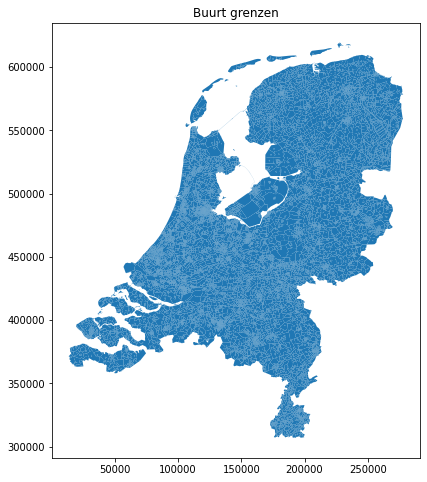

In [ ]:
ax = grenzen.plot(figsize=(10,8))
ax.title.set_text('Buurt grenzen')

In [ ]:
# Perform spatial join to match accident location and region polygons
logging.info('join start')
data = gpd.tools.sjoin(df.reset_index(drop=True), grenzen.to_crs(crs=df.crs), how='inner')
data.drop(['geometry','index_right'], axis=1,inplace=True)
logging.info('join end')

INFO:root:join start


2021-08-05 12:28:57,449 - root - INFO - join start
2021-08-05 12:28:57,449 - root - INFO - join start


INFO:root:join end


2021-08-05 12:29:03,140 - root - INFO - join end
2021-08-05 12:29:03,140 - root - INFO - join end


In [ ]:
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2100003 entries, 0 to 2085303
Data columns (total 8 columns):
 #   Column     Dtype   
---  ------     -----   
 0   JAAR_VKL   int16   
 1   AP3_CODE   category
 2   ANTL_PTJ   int8    
 3   AOL_ID     int8    
 4   MAXSNELHD  float16 
 5   X_COORD    float64 
 6   Y_COORD    float64 
 7   ID         float32 
dtypes: category(1), float16(1), float32(1), float64(2), int16(1), int8(2)
memory usage: 70.1 MB


In [ ]:
# Export for PowerBI
data.to_csv('ongevallen.csv',sep=';',decimal=',',index=False,float_format='%.8g')


# De informatie op de kaart plotten

Dit is even voor een eerste indruk, het serieuze werk doen we met Power BI en QGIS

In [ ]:
# load osm data for car driving
G = ox.graph_from_place('Ermelo, Netherlands', network_type='drive')

# Load Edges (streets) into GeoDataFrame
edges = ox.graph_to_gdfs(G,edges=True,nodes=False)
edges['maxspeed'] = pd.to_numeric(edges['maxspeed'], errors='coerce')

for u,v,x in edges[ (edges.maxspeed<=30)|(edges.maxspeed.isna()) ].index.values:
  G.remove_edge(u,v)


In [ ]:
from folium.plugins import MarkerCluster, FastMarkerCluster

def draw_map():

  map = folium.Map()

  #Create a FeatureGroup for points
  pointsgroup = folium.FeatureGroup(name='Points_Layer', control=True)

  #Use pointsgroup as the child of Map
  map.add_child(pointsgroup)

  ##Create a FeatureGroup of Marker
  markergroup = folium.FeatureGroup(name='Marker_Layer', control=True)

  #Use markergroup as the child of Map
  map.add_child(markergroup)

  #folium.LayerControl().add_to(map)
  marker_cluster = MarkerCluster().add_to(markergroup)

  codes = {'UMS':{'color':'green','text':'Uitsluitend Materiele Schade','radius':2},
          "LET":{'color':'orange','text':'Letsel','radius':5},
          'DOD':{'color':'red','text':'Dodelijk ongeval','radius':10}}


  def format_details(row):
    return '{} {}<br/>aard={}<br/>partijen={}</br>snelheid={:.0f}'.format(row.JAAR_VKL,codes[row.AP3_CODE]['text'],row.AOL_ID,row.ANTL_PTJ,row.MAXSNELHD)

  for row in df.itertuples():
    folium.Circle([row.X_COORD,row.Y_COORD],
                  radius=codes[row.AP3_CODE]['radius'],
                  color=codes[row.AP3_CODE]['color'],
                  tooltip=format_details(row)). \
                  add_to(pointsgroup)

  #df_local = df[ df.GME_NAAM=='Ermelo']
  df_local = df

  for row in df_local.itertuples():
    folium.Marker(location=[row.X_COORD,row.Y_COORD],                 
                  icon=folium.Icon(color=codes[row.AP3_CODE]['color']),
                  tooltip=format_details(row)). \
                  add_to(marker_cluster)

  #df_local = df[ df.GME_NAAM=='Ermelo']
  #FastMarkerCluster(data=list(zip(df_local['X_COORD'].values, df['Y_COORD'].values))).add_to(map)

  folium.LayerControl().add_to(map)

  map = ox.folium.plot_graph_folium(G,graph_map=map,popup_attribute='maxspeed')

  map

  return map

draw_map()
# AOL_ID aard ongeval
# OTE_ID Objecttype

# Experimenteel

In [ ]:
#ox.get_nearest_edges(G,df_local.X_COORD.values,df_local.Y_COORD.values)
x = df_local.X_COORD.values.tolist()
y = df_local.Y_COORD.values.tolist()
e = ox.distance.nearest_edges(G,x[0],y[0],interpolate=0.000001)


G.edges.get(e)

In [ ]:
edges.to_crs('WGS84')

In [ ]:
edges.set_crs(epsg=3395)

In [ ]:
G.edges[e[0],e[1],e[2]]

In [ ]:
#get metadata
!wget "https://geo.rijkswaterstaat.nl/services/ogc/gdr/nwb_wegen/ows?service=WFS&version=2.0.0&request=DescribeFeatureType&typeName=wegvakken" -O metadata.txt#download data
!wget "https://geo.rijkswaterstaat.nl/services/ogc/gdr/nwb_wegen/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=wegvakken&outputFormat=csv" -O NWB_Wegvakken.csv
#!wget http://geodata.nationaalgeoregister.nl/nwbwegen/extract/nwbwegen.zip

#https://openmaps.gov.bc.ca/geo/pub/wfs?SERVICE=WFS&VERSION=2.0.0&
#REQUEST=DescribeFeatureType&typenames=WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW
to figure out a way where I can limit the attributes returned by a wfs call. If we use this example, I am expecting that this call would only return the GEOMETRY and the LOCALITY attribute

https://openmaps.gov.bc.ca/geo/pub/wfs?
SERVICE=WFS&
VERSION=2.0.0&
REQUEST=GetFeature&
outputFormat=application%2Fjson&
typeNames=WHSE_IMAGERY_AND_BASE_MAPS.GSR_AIRPORTS_SVW&
SRSNAME=EPSG%3A3005&
propertyName=LOCALITY&
COUNT=10

!wget "https://geo.rijkswaterstaat.nl/services/ogc/gdr/nwb_wegen/ows?service=WFS&version=2.0.0&request=DescribeFeatureType&typeName=wegvakken" -O metadata.txt

#!head "/content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Netwerkgegevens/wegvakken.txt"
pd.read_csv("/content/data/01-01-2003_31-12-2003/01-01-2003_31-12-2003/02 TOTNL J-N-J-N/Netwerkgegevens/wegvakken.txt",nrows=5)
pd